### Task parameters

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import keras
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 556.6 MB 20 kB/s 
     |████████████████████████████████| 439 kB 93.1 MB/s 
     |████████████████████████████████| 5.7 MB 87.4 MB/s 
     |████████████████████████████████| 1.7 MB 69.0 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0-dev20221213


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-12-14 10:28:36--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.2’

train-data.tsv.2    100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2022-12-14 10:28:36 (12.3 MB/s) - ‘train-data.tsv.2’ saved [358233/358233]

--2022-12-14 10:28:36--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.2’

valid-data.tsv.2    100%[====

### Data preparation

In [ ]:
train_data = pd.read_csv(train_file_path, sep = '\t', header = None)
test_data = pd.read_csv(test_file_path, sep = '\t', header = None)

In [ ]:
train_data.head()

,0,1
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


### Cleaning data

In [ ]:
train_data.isna().any()


0    False
1    False
dtype: bool

In [ ]:
test_data.isna().any()

0    False
1    False
dtype: bool

### Separation dataset from labels

In [ ]:
train_labels = pd.factorize(train_data[0])[0]
test_labels = pd.factorize(test_data[0])[0]

In [ ]:
train_labels[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
train_data[1].values[0:5]

array(['ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.',
       'you can never do nothing',
       'now u sound like manky scouse boy steve,like! i is travelling on da bus home.wot has u inmind 4 recreation dis eve?',
       'mum say we wan to go then go... then she can shun bian watch da glass exhibition...',
       'never y lei... i v lazy... got wat? dat day ü send me da url cant work one...'],
      dtype=object)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train_data[1].values, train_labels))
test_data = tf.data.Dataset.from_tensor_slices(
    (test_data[1].values, test_labels))

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000

encoder = TextVectorization(
    output_mode='int',
    max_tokens=VOCAB_SIZE,
    output_sequence_length=VOCAB_SIZE)

encoder.adapt(train_data.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

### Model itself

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

### Fitting model

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    validation_steps=30,
    epochs=10)

Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.8660

66/66 [==============================] - 103s 1s/step - loss: 0.6646 - accuracy: 0.8660 - val_loss: 0.6153 - val_accuracy: 0.8657
Epoch 2/10
66/66 [==============================] - 85s 1s/step - loss: 0.5371 - accuracy: 0.8660
Epoch 3/10
66/66 [==============================] - 86s 1s/step - loss: 0.4143 - accuracy: 0.8660
Epoch 4/10
66/66 [==============================] - 81s 1s/step - loss: 0.2725 - accuracy: 0.8660
Epoch 5/10
66/66 [==============================] - 83s 1s/step - loss: 0.1476 - accuracy: 0.9342
Epoch 6/10
66/66 [==============================] - 81s 1s/step - loss: 0.0970 - accuracy: 0.9768
Epoch 7/10
66/66 [==============================] - 83s 1s/step - loss: 0.0722 - accuracy: 0.9813
Epoch 8/10
66/66 [==============================] - 81s 1s/step - loss: 0.0596 - accuracy: 0.9837
Epoch 9/10
66/66 [==============================] - 81s 1s/step - loss: 0.0514 - accuracy: 0.9859
Epoch 10/10
66/66 [==============================] - 82s 1s/step - loss: 0.0450 - accu

### Create graphics of loss metrics & the accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

22/22 [==============================] - 6s 294ms/step - loss: 0.0572 - accuracy: 0.9835
Test Loss: 0.05724693834781647
Test Accuracy: 0.983476996421814


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6955555723980069)

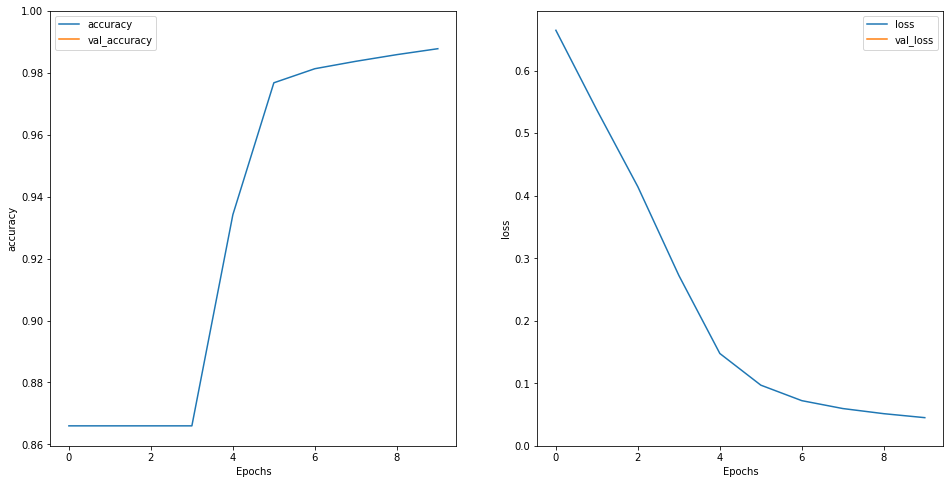

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### Assessment

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  predict = model.predict([pred_text])[0][0]
  return [predict, "ham" if predict < 0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 2s 2s/step
[-3.9957316, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 81ms/step
You passed the challenge. Great job!


## Second configuration

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000

encoder = TextVectorization(
    output_mode='int',
    max_tokens=VOCAB_SIZE,
    output_sequence_length=VOCAB_SIZE)

encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    validation_steps=30,
    epochs=10)

Epoch 1/10
131/131 [==============================] - 251s 2s/step - loss: 0.6037 - accuracy: 0.8660 - val_loss: 0.4877 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 233s 2s/step - loss: 0.3821 - accuracy: 0.8660 - val_loss: 0.2433 - val_accuracy: 0.8604
Epoch 3/10
131/131 [==============================] - 231s 2s/step - loss: 0.1567 - accuracy: 0.9385 - val_loss: 0.1099 - val_accuracy: 0.9667
Epoch 4/10
131/131 [==============================] - 232s 2s/step - loss: 0.0883 - accuracy: 0.9792 - val_loss: 0.0793 - val_accuracy: 0.9823
Epoch 5/10
131/131 [==============================] - 234s 2s/step - loss: 0.0670 - accuracy: 0.9856 - val_loss: 0.0707 - val_accuracy: 0.9844
Epoch 6/10
131/131 [==============================] - 232s 2s/step - loss: 0.0526 - accuracy: 0.9880 - val_loss: 0.0595 - val_accuracy: 0.9865
Epoch 7/10
131/131 [==============================] - 234s 2s/step - loss: 0.0449 - accuracy: 0.9902 - val_loss: 0.0674 - val_accuracy: 0.9781

KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 15s 330ms/step - loss: 0.0585 - accuracy: 0.9828
Test Loss: 0.058535099029541016
Test Accuracy: 0.982758641242981


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6340559601783753)

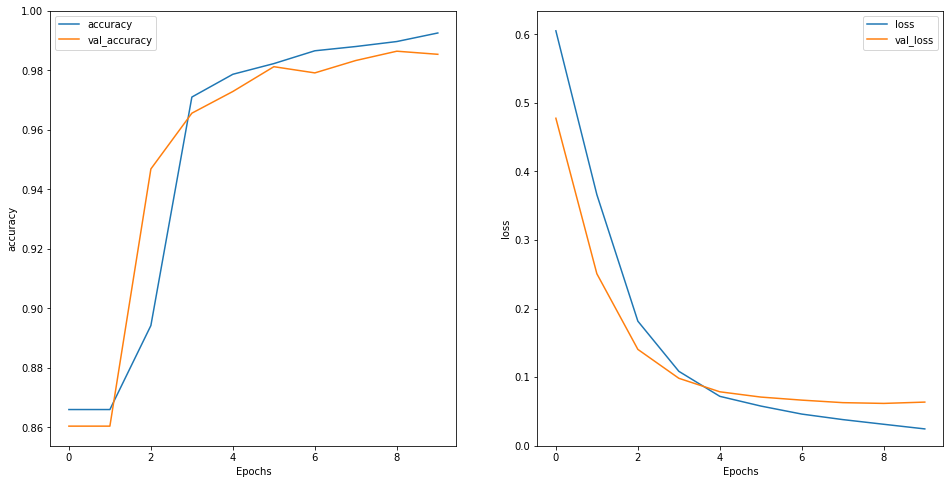

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  predict = model.predict([pred_text])[0][0]
  return [predict, "ham" if predict < 0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 4s 4s/step
[-6.8289223, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      print(msg, prediction)
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 166ms/step
You passed the challenge. Great job!
